## Towards the comparison of the signal-to-noise achieved with different filter widths

## Signal-to-noise calculations

As a function of exposure time, what is the signal-to-noise for the different filter widths?

How does that change when the CWL of the filters changes?

What is the benefit of the narrow bandwidth filters over larger bandwidth?


### Some background

The SNR is calculated following the equation (see, e.g., pg 407 of "Spectroscopic Instrumentation" by Eversberg and Vollmann): 

$SNR = \frac{I t}{\sqrt{I t + B t + D t + R^2}}$, 

where I is the signal over some number of pixels, B is the sky background over some number of pixels, D is the dark current over some number of pixels and R is the readout noise of the detector.  The exposure time, t, is usually given in seconds.

In [100]:
def Dragonfly(number_of_lenses = 48.,QE = 0.48,R_in = None,CMOS = False):
    area_lens = np.pi*(14.3/2)**2 * number_of_lenses * u.cm**2  # 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                              # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now

    # The following are per pixel
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    
    if CMOS:
        print "VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)"
        QE = 0.70                # quantum efficiency of the CMOS detector
        R = 2.                   # read noise (electrons)
    else:
        print "VERBOSE: Using old cameras... (QE = 0.48, R = 10.)"
        QE = 0.48                # quantum efficiency of the CCDs
        R = 10.                  # read noise (electrons)

    R_squared = R**2 * u.photon
    
    if R_in is not None:
        R_squared = R_in**2 * u.photon
        print "VERBOSE: Modifying read noise with given input R = %s"%R_in
    
    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared]

numlens = 48.
[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(number_of_lenses=numlens,CMOS=False,R_in=4.)
print R_squared

VERBOSE: Using old cameras... (QE = 0.48, R = 10.)
VERBOSE: Modifying read noise with given input R = 4.0
16.0 ph


In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
import math

### from SkyBackground_FilterWidthComparison

Gemini and UVES total flux of sky background, CWL 656.3 and bandwidth 3.0: 	 1.57145454545, 1.39560311964<br>
Gemini and UVES total flux of sky background, CWL 656.3 and bandwidth 0.8: 	 0.388826666667, 0.332159792854<br>
Gemini and UVES total flux of sky background, CWL 655.8 and bandwidth 0.8: 	 0.428533333333, 0.220765928889<br>
Gemini and UVES total flux of sky background, CWL 657.3 and bandwidth 0.8: 	 0.432533333333, 0.230907383733<br>
<br>
Gemini and UVES total flux of sky background, CWL 659.9 and bandwidth 3.0: 	 1.42516363636, 0.964744735582<br>
Gemini and UVES total flux of sky background, CWL 659.9 and bandwidth 0.8: 	 0.37848, 0.258665857703<br>
Gemini and UVES total flux of sky background, CWL 659.1 and bandwidth 0.8: 	 0.378506666667, 0.225613358856<br>

In [93]:
[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(number_of_lenses=numlens,CMOS=True)

B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2  

# Gemini (G) and UVES (U) 
# centred at 656.3 nm
B_3nm_G_1  = 1.52495*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_08nm_G_1 = 0.383995*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_3nm_U_1  = 1.39467*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_08nm_U_1 = 0.3325*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
# centred at 657.3 (within the 656.3 nm bandpass, but avoiding sky lines)
B_08nm_G_3 = 0.432533333333 *u.photon/u.second/u.arcsec**2/u.m**2 
B_08nm_U_3 = 0.230907383733 *u.photon/u.second/u.arcsec**2/u.m**2 

# centred at 659.9 nm
B_3nm_G_2  = 1.42516*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_08nm_G_2 = 0.37848*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_3nm_U_2  = 0.96474*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_08nm_U_2 = 0.25867*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
# centred at 659.1 (within the 659.9 nm bandpass, but avoiding sky lines)
B_08nm_G_4 = 0.3785*u.photon/u.second/u.arcsec**2/u.m**2
B_08nm_U_4 = 0.2256*u.photon/u.second/u.arcsec**2/u.m**2  

#SB_ph_one = 10**-2. * u.photon / (u.cm**2 * u.rad**2 * u.second)
#SB_ph_two = 10**-1. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_zero = 10**0. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_one = 10**1. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_two = 10**2. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_three = 10**3. * u.photon / (u.cm**2 * u.rad**2 * u.second)

numpixel = 100.0 * 100.0/(pix_size**2)   # 100-arcsec-a-side pixels
#numpixel = 10.0 * 10.0/(pix_size**2)   # 10-arcsec-a-side pixels

def calcSNR(SB_ph,B,time,explength=30.*(60.*u.second)):
    numexp=1
    if isinstance(time.value, (np.ndarray)):
        numexp = np.array([math.ceil(thistime/explength) for thistime in time])
    else:
        numexp = math.ceil(time/explength) # round up the number of exposures
        
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    print('total S: %s'%S)
    print('total B: %s'%B_tot)
    #sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel*numlens + R_squared*numpixel*numlens*numexp)
    SNR = signal/sigma
    return SNR

time = 60.*60.*60. * u.second
#print isinstance(time.value, (np.ndarray))
SNR = calcSNR(SB_ph_three,B_3nm_G_1,time)
print SNR
print ""
time = 60.*60.*60. * u.second
SNR = calcSNR(SB_ph_three,B_08nm_G_1,time)
print SNR

VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
total S: 0.000845249922916 ph / s
total B: 5.48391873526 ph / s
5.11908867968 ph(1/2)

total S: 0.000845249922916 ph / s
total B: 1.38089601282 ph / s
7.5993806828 ph(1/2)


In [99]:
def checkSkyLimited(B,time,explength=30.*(60.*u.second)):
    numexp = math.ceil(time.value/explength.value) # round up the number of exposures
    print 'In exposure length of %s, sky background of %s, the number of exposures is %s:'%\
                (time.to(u.minute),B,numexp)
    B_all = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)*time
    R_all = R_squared*numlens*numexp
    D_all = D*time*numlens
    print 'B/R: %s' %(B_all/R_all)
    print 'B/D: %s' %(B_all/D_all)

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(number_of_lenses=numlens,CMOS=False)
time = (60.* u.second) * 10.
checkSkyLimited(B_3nm_G_1,time)
checkSkyLimited(B_08nm_G_1,time)

print ''

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(number_of_lenses=numlens,CMOS=True)
time = (60.* u.second) * 10.
checkSkyLimited(B_3nm_G_1,time)
checkSkyLimited(B_08nm_G_1,time)

print ''

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(number_of_lenses=numlens,CMOS=True,R_in=0.)
time = (60.* u.second) * 30.
checkSkyLimited(B_3nm_G_1,time)
checkSkyLimited(B_08nm_G_1,time)

VERBOSE: Using old cameras... (QE = 0.48, R = 10.)
In exposure length of 10.0 min, sky background of 1.52495 ph / (arcsec2 m2 s), the number of exposures is 1.0:
B/R: 0.470050177308
B/D: 7.8341696218
In exposure length of 10.0 min, sky background of 0.383995 ph / (arcsec2 m2 s), the number of exposures is 1.0:
B/R: 0.118362515384
B/D: 1.97270858974

VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
In exposure length of 10.0 min, sky background of 1.52495 ph / (arcsec2 m2 s), the number of exposures is 1.0:
B/R: 17.1372460477
B/D: 11.4248306985
In exposure length of 10.0 min, sky background of 0.383995 ph / (arcsec2 m2 s), the number of exposures is 1.0:
B/R: 4.31530004006
B/D: 2.87686669337

VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
VERBOSE: Modifying read noise with given input R = 0.0
In exposure length of 30.0 min, sky background of 1.52495 ph / (arcsec2 m2 s), the number of exposures is 1.0:
B/R: inf
B/D: 11.4248306985
In exposure length of 30.0 min, sky backgrou

In [127]:
def calcTime(SNR,SB_ph,B,explength=30.*(60.*u.second)):
   # sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel*numlens + R_squared*numpixel*numlens*numexp)

    SNR = SNR*(u.photon)/np.sqrt(1*u.photon)
    I = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)*numpixel 
    L = SNR**2 * (I + B_tot + D*numpixel*numlens) 
    M = np.sqrt(L**2 + 4*(I**2)*(SNR**2*R_squared*numpixel*numlens*120.)) # missing times numexp here (should be ~120)
    N = 2*I**2
    return (L + M)/N

def calcTime2(SNR,SB_ph,B,explength=30.*(60.*u.second)):
    SNR = SNR*(u.photon)/np.sqrt(1*u.photon)
    I = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)*numpixel 
    TOP = SNR**2 * (I + B_tot + D*numpixel*numlens + R_squared*numpixel*numlens/explength) 
    BOTTOM = I**2
    return TOP/BOTTOM

# check against output above
print calcTime(5.11908867968,SB_ph_three,B_3nm_G_1).to(u.hour)
print calcTime2(5.11908867968,SB_ph_three,B_3nm_G_1).to(u.hour)

59.9999999999 h
59.9999999999 h


In [62]:
plt.style.use('seaborn-dark-palette')
plt.style.use('ggplot')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)


SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
total S: 0.000845249922916 ph / s
total B: 5.48391873526 ph / s
total S: 0.000845249922916 ph / s
total B: 1.38089601282 ph / s
total S: 0.000845249922916 ph / s
total B: 1.55544617875 ph / s
Gemini, 3nm vs 0.8nm, time to reach SNR 5: 58.87 hr and 27.60 hr, aka 2.13 x difference
total S: 0.000845249922916 ph / s
total B: 5.01541489394 ph / s
total S: 0.000845249922916 ph / s
total B: 1.19571328862 ph / s
total S: 0.000845249922916 ph / s
total B: 0.830373014042 ph / s
UVES, 3nm vs 0.8nm, time to reach SNR 5: 55.30 hr and 26.20 hr, aka 2.11 x difference


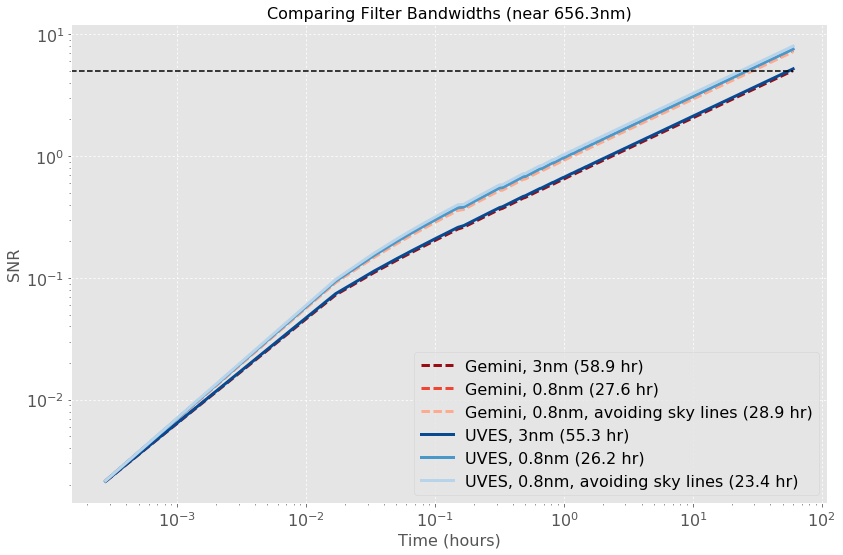

In [118]:
def plotSNR(SB_ph,B,time,refSNR=5.0,linestyle='-',label='',colour='black'):
    SNR = calcSNR(SB_ph,B,time,explength=10.*(60.*u.second))
    ind = (np.abs(SNR.value-refSNR)).argmin()
    plt.plot(time/3600.,SNR,label=label+' (%.1f hr)'%(time[ind]/3600.).value,\
             linewidth=3,linestyle=linestyle,color=colour)
    return SNR,ind,time[ind]/3600.

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(number_of_lenses=numlens,CMOS=True,R_in=None)

# pick how long to calculate SNR over
time = np.arange(1,60.*60.*1000000.,1000)* u.second
time = np.arange(1,60.*60.*60.,60.)* u.second
limit = time[-1]/u.second

# reference signal-to-noise for comparison
refSNR = 5.0

reds = plt.get_cmap("Reds")
blues = plt.get_cmap("Blues")

plt.figure(figsize=(12,8))

# Gemini at 656.3nm
SNR,ind,G_3nm_1 = plotSNR(SB_ph_three,B_3nm_G_1,time,refSNR=5.0,linestyle='--',label='Gemini, 3nm',colour=reds(0.9))
SNR,ind,G_08nm_1 = plotSNR(SB_ph_three,B_08nm_G_1,time,refSNR=5.0,linestyle='--',label='Gemini, 0.8nm',colour=reds(0.6))
SNR,ind,G_08nm_2 = plotSNR(SB_ph_three,B_08nm_G_3,time,refSNR=5.0,linestyle='--',\
                           label='Gemini, 0.8nm, avoiding sky lines',colour=reds(0.3))
print 'Gemini, 3nm vs 0.8nm, time to reach SNR 5: %.2f hr and %.2f hr, aka %.2f x difference'%\
            (G_3nm_1.value,G_08nm_1.value,G_3nm_1.value/G_08nm_1.value)

# UVES at 656.3nm
SNR,ind,U_3nm_1 = plotSNR(SB_ph_three,B_3nm_U_1,time,refSNR=5.0,linestyle='-',label='UVES, 3nm',colour=blues(0.9))
SNR,ind,U_08nm_1 = plotSNR(SB_ph_three,B_08nm_U_1,time,refSNR=5.0,linestyle='-',label='UVES, 0.8nm',colour=blues(0.6))
SNR,ind,U_08nm_2 = plotSNR(SB_ph_three,B_08nm_U_3,time,refSNR=5.0,linestyle='-',\
                           label='UVES, 0.8nm, avoiding sky lines',colour=blues(0.3))
print 'UVES, 3nm vs 0.8nm, time to reach SNR 5: %.2f hr and %.2f hr, aka %.2f x difference'%\
            (U_3nm_1.value,U_08nm_1.value,U_3nm_1.value/U_08nm_1.value)


plt.plot([0,limit/3600.],[refSNR,refSNR],'k--')   
plt.xlabel('Time (hours)')
plt.ylabel('SNR')
plt.title('Comparing Filter Bandwidths (near 656.3nm)')
plt.grid(linestyle=':')
plt.legend()

loglog=True
loglogind=''
if loglog:
    plt.yscale('log')
    plt.xscale('log')
    loglogind='_loglog'
else:
    plt.xlim(0,limit/3600.)
    plt.ylim(0,10)

plt.tight_layout()
plt.savefig('SignalToNoise_FilterWidthComparison_refSNR5%s.pdf'%loglogind)

VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
VERBOSE: Modifying read noise with given input R = 0.0
total S: 0.000845249922916 ph / s
total B: 5.48391873526 ph / s
total S: 0.000845249922916 ph / s
total B: 1.38089601282 ph / s
total S: 0.000845249922916 ph / s
total B: 1.55544617875 ph / s
Gemini, 3nm vs 0.8nm, time to reach SNR 5: 2.25 hr and 1.00 hr, aka 2.25 x difference
total S: 0.000845249922916 ph / s
total B: 5.01541489394 ph / s
total S: 0.000845249922916 ph / s
total B: 1.19571328862 ph / s
total S: 0.000845249922916 ph / s
total B: 0.830373014042 ph / s
UVES, 3nm vs 0.8nm, time to reach SNR 5: 2.12 hr and 0.95 hr, aka 2.23 x difference


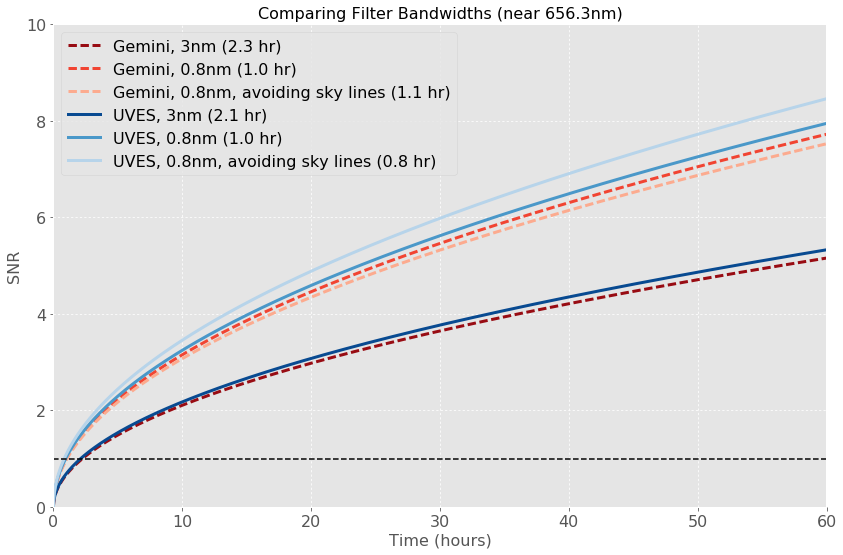

In [103]:
[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(number_of_lenses=numlens,CMOS=True,R_in=0.)

# pick how long to calculate SNR over
time = np.arange(1,60.*60.*1000000.,1000)* u.second
time = np.arange(1,60.*60.*60.,60.)* u.second
limit = time[-1]/u.second

# reference signal-to-noise for comparison
refSNR = 1.0

reds = plt.get_cmap("Reds")
blues = plt.get_cmap("Blues")

plt.figure(figsize=(12,8))

# Gemini at 656.3nm
SNR,ind,G_3nm_1 = plotSNR(SB_ph_three,B_3nm_G_1,time,refSNR=refSNR,linestyle='--',label='Gemini, 3nm',colour=reds(0.9))
SNR,ind,G_08nm_1 = plotSNR(SB_ph_three,B_08nm_G_1,time,refSNR=refSNR,linestyle='--',label='Gemini, 0.8nm',colour=reds(0.6))
SNR,ind,G_08nm_2 = plotSNR(SB_ph_three,B_08nm_G_3,time,refSNR=refSNR,linestyle='--',\
                           label='Gemini, 0.8nm, avoiding sky lines',colour=reds(0.3))
print 'Gemini, 3nm vs 0.8nm, time to reach SNR 5: %.2f hr and %.2f hr, aka %.2f x difference'%\
            (G_3nm_1.value,G_08nm_1.value,G_3nm_1.value/G_08nm_1.value)

# UVES at 656.3nm
SNR,ind,U_3nm_1 = plotSNR(SB_ph_three,B_3nm_U_1,time,refSNR=refSNR,linestyle='-',label='UVES, 3nm',colour=blues(0.9))
SNR,ind,U_08nm_1 = plotSNR(SB_ph_three,B_08nm_U_1,time,refSNR=refSNR,linestyle='-',label='UVES, 0.8nm',colour=blues(0.6))
SNR,ind,U_08nm_2 = plotSNR(SB_ph_three,B_08nm_U_3,time,refSNR=refSNR,linestyle='-',\
                           label='UVES, 0.8nm, avoiding sky lines',colour=blues(0.3))
print 'UVES, 3nm vs 0.8nm, time to reach SNR 5: %.2f hr and %.2f hr, aka %.2f x difference'%\
            (U_3nm_1.value,U_08nm_1.value,U_3nm_1.value/U_08nm_1.value)


plt.plot([0,limit/3600.],[refSNR,refSNR],'k--')   
plt.xlim(0,limit/3600.)
plt.ylim(0,10)
plt.xlabel('Time (hours)')
plt.ylabel('SNR')
plt.title('Comparing Filter Bandwidths (near 656.3nm)')
plt.grid(linestyle=':')
plt.legend()
plt.tight_layout()
plt.savefig('SignalToNoise_FilterWidthComparison_refSNR1.pdf')

total S: 0.000579599947142 ph / s
total B: 3.51432747667 ph / s
total S: 0.000579599947142 ph / s
total B: 0.933300586158 ph / s
total S: 0.000579599947142 ph / s
total B: 0.933349904514 ph / s
Gemini, 3nm vs 0.8nm, time to reach SNR 5: 57.62 hr and 15.78 hr, aka 3.65 x difference
total S: 0.000579599947142 ph / s
total B: 2.37896958225 ph / s
total S: 0.000579599947142 ph / s
total B: 0.637858969091 ph / s
total S: 0.000579599947142 ph / s
total B: 0.55631106594 ph / s
UVES, 3nm vs 0.8nm, time to reach SNR 5: 39.22 hr and 11.00 hr, aka 3.57 x difference


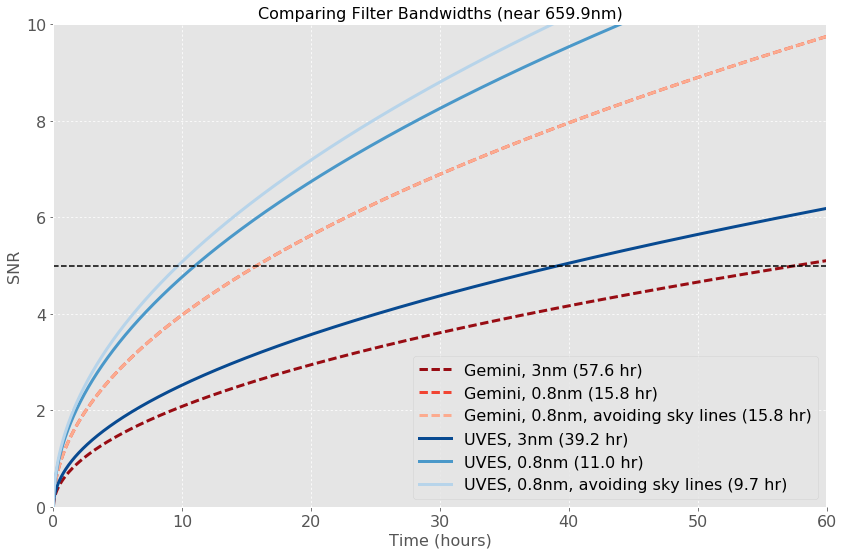

In [97]:
# pick how long to calculate SNR over
time = np.arange(1,60.*60.*1000000.,1000)* u.second
time = np.arange(1,60.*60.*60.,60.)* u.second
limit = time[-1]/u.second

# reference signal-to-noise for comparison
refSNR = 5.0

reds = plt.get_cmap("Reds")
blues = plt.get_cmap("Blues")

plt.figure(figsize=(12,8))

# Gemini at 656.3nm
SNR,ind,G_3nm_1 = plotSNR(SB_ph_three,B_3nm_G_2,time,refSNR=refSNR,linestyle='--',label='Gemini, 3nm',colour=reds(0.9))
SNR,ind,G_08nm_1 = plotSNR(SB_ph_three,B_08nm_G_2,time,refSNR=refSNR,linestyle='--',label='Gemini, 0.8nm',colour=reds(0.6))
SNR,ind,G_08nm_2 = plotSNR(SB_ph_three,B_08nm_G_4,time,refSNR=refSNR,linestyle='--',\
                           label='Gemini, 0.8nm, avoiding sky lines',colour=reds(0.3))
print 'Gemini, 3nm vs 0.8nm, time to reach SNR 5: %.2f hr and %.2f hr, aka %.2f x difference'%\
            (G_3nm_1.value,G_08nm_1.value,G_3nm_1.value/G_08nm_1.value)

# UVES at 656.3nm
SNR,ind,U_3nm_1 = plotSNR(SB_ph_three,B_3nm_U_2,time,refSNR=refSNR,linestyle='-',label='UVES, 3nm',colour=blues(0.9))
SNR,ind,U_08nm_1 = plotSNR(SB_ph_three,B_08nm_U_2,time,refSNR=refSNR,linestyle='-',label='UVES, 0.8nm',colour=blues(0.6))
SNR,ind,U_08nm_2 = plotSNR(SB_ph_three,B_08nm_U_4,time,refSNR=refSNR,linestyle='-',\
                           label='UVES, 0.8nm, avoiding sky lines',colour=blues(0.3))
print 'UVES, 3nm vs 0.8nm, time to reach SNR 5: %.2f hr and %.2f hr, aka %.2f x difference'%\
            (U_3nm_1.value,U_08nm_1.value,U_3nm_1.value/U_08nm_1.value)


plt.plot([0,limit/3600.],[refSNR,refSNR],'k--')   
plt.xlim(0,limit/3600.)
plt.ylim(0,10)
plt.xlabel('Time (hours)')
plt.ylabel('SNR')
plt.title('Comparing Filter Bandwidths (near 659.9nm)')
plt.grid(linestyle=':')
plt.legend()
plt.tight_layout()
#plt.savefig('SignalToNoise_FilterWidthComparison_refSNR1.pdf')